In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report

datas = pd.read_parquet('/kaggle/input/binance-full-history/BTC-USDT.parquet')

datas.info()
datas.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2394622 entries, 2017-08-17 04:00:00 to 2022-03-12 23:59:00
Data columns (total 9 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   open                          float32
 1   high                          float32
 2   low                           float32
 3   close                         float32
 4   volume                        float32
 5   quote_asset_volume            float32
 6   number_of_trades              uint16 
 7   taker_buy_base_asset_volume   float32
 8   taker_buy_quote_asset_volume  float32
dtypes: float32(8), uint16(1)
memory usage: 95.9 MB


,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
open_time,,,,,,,,,
2017-08-17 04:00:00,4261.479980,4261.479980,4261.479980,4261.479980,1.775183,7564.906738,3,0.075183,320.390839
2017-08-17 04:01:00,4261.479980,4261.479980,4261.479980,4261.479980,0.000000,0.000000,0,0.000000,0.000000
2017-08-17 04:02:00,4280.560059,4280.560059,4280.560059,4280.560059,0.261074,1117.542969,2,0.261074,1117.542969
2017-08-17 04:03:00,4261.479980,4261.479980,4261.479980,4261.479980,0.012008,51.171852,3,0.012008,51.171852
2017-08-17 04:04:00,4261.479980,4261.479980,4261.479980,4261.479980,0.140796,599.999329,1,0.140796,599.999329


In [2]:
datas=datas.rename(columns={"open":"Open","high":"High","low":"Low","close":"Close"})
datas['signal'] = 0.0

# Create short simple moving average over the short window
datas['short_mavg'] = datas['Close'].rolling(window=30, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
datas['long_mavg'] = datas['Close'].rolling(window=120, min_periods=1, center=False).mean()

# Create signals
datas['signal'] = np.where(datas['short_mavg'] > datas['long_mavg'], 1.0, 0.0)

In [3]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
datas['EMA21'] = EMA(datas, 21)
datas['EMA63'] = EMA(datas, 63)
datas['EMA252'] = EMA(datas, 252)
datas.head()

#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
datas['ROC21'] = ROC(datas['Close'], 21)
datas['ROC63'] = ROC(datas['Close'], 63)

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
datas['MOM21'] = MOM(datas['Close'], 21)
datas['MOM63'] = MOM(datas['Close'], 63)

#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 #rs = pd.stats.moments.ewma(u, com=period-1, adjust=False)
 rs=pd.DataFrame.ewm(u,com=period-1,adjust=False).mean() 
 pd.DataFrame.ewm(d,com=period-1,adjust=False).mean()
 #pd.stats.moments.ewma(d, com=period-1, adjust=False)
 return 100 - 100 / (1 + (rs))
datas['RSI21'] = RSI(datas['Close'], 21)
datas['RSI63'] = RSI(datas['Close'], 63)
datas['RSI252'] = RSI(datas['Close'], 252)

#calculation of stochastic osillator.

def STOK(close, low, high, n): 
 STOK = ((close - low.rolling(n).mean()) / (high.rolling(n).mean() - low.rolling(n).mean())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).mean()) / (high.rolling(n).mean() - low.rolling(n).mean())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD
datas['%K21'] = STOK(datas['Close'], datas['Low'], datas['High'], 21)
datas['%D21'] = STOD(datas['Close'], datas['Low'], datas['High'], 21)
datas['%K63'] = STOK(datas['Close'], datas['Low'], datas['High'], 63)
datas['%D63'] = STOD(datas['Close'], datas['Low'], datas['High'], 63)
datas['%K252'] = STOK(datas['Close'], datas['Low'], datas['High'], 252)
datas['%D252'] = STOD(datas['Close'], datas['Low'], datas['High'], 252)
#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
datas['MA21'] = MA(datas, 21)
datas['MA63'] = MA(datas, 63)
datas['MA252'] = MA(datas, 252)
datas.tail()

,Open,High,Low,Close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,signal,...,RSI252,%K21,%D21,%K63,%D63,%K252,%D252,MA21,MA63,MA252
open_time,,,,,,,,,,,,,,,,,,,,,
2022-03-12 23:55:00,38866.308594,38866.320312,38850.921875,38851.988281,8.074230,3.137436e+05,309,3.33971,1.297662e+05,0.0,...,84.925666,-197.125461,-166.278319,-776.625703,-723.103562,-1456.667765,-1345.164980,38917.912946,39039.255270,39089.768353
2022-03-12 23:56:00,38851.988281,38852.000000,38832.769531,38832.781250,13.332140,5.178579e+05,500,7.56758,2.939344e+05,0.0,...,84.874693,-257.530116,-211.174496,-839.510745,-783.781290,-1570.362856,-1465.623055,38909.643043,39034.283730,39088.895384
2022-03-12 23:57:00,38832.781250,38853.929688,38828.601562,38830.710938,10.660070,4.140132e+05,422,4.08890,1.588085e+05,0.0,...,84.823578,-241.589048,-232.081542,-835.237647,-817.124698,-1571.100921,-1532.710514,38902.343564,39029.834511,39088.044984
2022-03-12 23:58:00,38830.710938,38839.660156,38730.671875,38737.281250,73.891029,2.865214e+06,1759,18.69545,7.246995e+05,0.0,...,84.772322,-486.348315,-328.489160,-1137.486900,-937.411764,-2097.821946,-1746.428574,38891.717820,39024.013393,39086.852136
2022-03-12 23:59:00,38737.281250,38815.429688,38737.281250,38807.359375,62.249580,2.413725e+06,1385,40.21999,1.559278e+06,0.0,...,85.343660,-211.755850,-313.231071,-807.879939,-926.868162,-1632.228649,-1767.050505,38884.877232,39018.638641,39085.960348


In [4]:
datasubs=datas.dropna()
datasubs=datasubs.drop(['Close','High','Low','Open', 'volume','quote_asset_volume','number_of_trades','taker_buy_base_asset_volume','taker_buy_quote_asset_volume'], axis=1)
datasubs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2391433 entries, 2017-08-17 08:13:00 to 2022-03-12 23:59:00
Data columns (total 22 columns):
 #   Column      Dtype  
---  ------      -----  
 0   signal      float64
 1   short_mavg  float64
 2   long_mavg   float64
 3   EMA21       float64
 4   EMA63       float64
 5   EMA252      float64
 6   ROC21       float32
 7   ROC63       float32
 8   MOM21       float32
 9   MOM63       float32
 10  RSI21       float64
 11  RSI63       float64
 12  RSI252      float64
 13  %K21        float64
 14  %D21        float64
 15  %K63        float64
 16  %D63        float64
 17  %K252       float64
 18  %D252       float64
 19  MA21        float64
 20  MA63        float64
 21  MA252       float64
dtypes: float32(4), float64(18)
memory usage: 383.1 MB


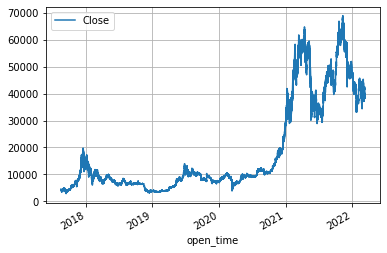

upward  51.72116467406781% out of 2391433 total datasize


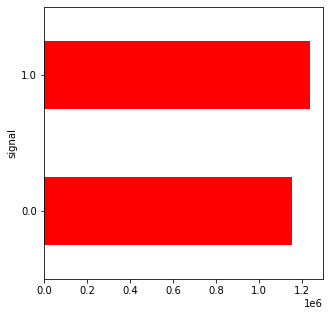

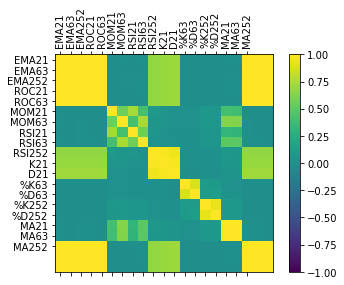

In [5]:
daily_close_px = datas[['Close']]
daily_close_px.plot(grid=True)
plt.show()

fig = plt.figure()
fig.set_size_inches(5,5)
data_s = datasubs.groupby(['signal']).size()
names=['EMA21','EMA63','EMA252','ROC21','ROC63','MOM21','MOM63','RSI21','RSI63','RSI252','K21','D21','%K63','%D63','%K252','%D252','MA21','MA63','MA252']

print("upward  {}% out of {} total datasize".format(100* data_s[1]/(data_s[1]+data_s[0]), data_s[1]+data_s[0]))
plot = data_s.plot(kind='barh', color='red')
X=datasubs.drop(['signal'], axis=1)
y=datasubs['signal']



correlations = X.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,19,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names, rotation = 90)
ax.set_yticklabels(names)
plt.show()

            Importance
EMA21         1.231019
EMA63         1.237630
MA21          1.237691
short_mavg    1.242562
MA63          1.244650
EMA252        1.260600
MA252         1.265014
long_mavg     1.300572
RSI63         2.087818
RSI21         2.107680
RSI252        2.140081
MOM21         3.015519
ROC21         3.354998
%K63          3.905358
%D21          4.308470
%K21          4.798140
%D63          5.391066
%K252        11.962336
MOM63        12.563187
%D252        16.281007
ROC63        18.064604


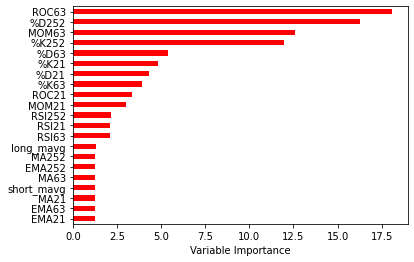

In [6]:
forest = RandomForestClassifier(n_estimators=100,random_state=1,n_jobs=-1)
forest.fit(X, y)
Importance = pd.DataFrame({'Importance':forest.feature_importances_*100}, index=X.columns)
print(Importance.sort_values('Importance', axis=0, ascending=True))
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None